# Práctica 2 de Reconocimiento de Patrones:
## Mejoramiento de la Imagen

Integrantes:
 - Diego Fernández Chaparro Plata Javier
 - Velázquez Sánchez José Antonio
 - Vargas Castro Daniel
 
### Objetivos
El alumno:
 - Aprenderá a mejorar la imagen de acuerdo a las modificaciones que se  le realizan original mente
 - Entenderá aumentar las características de contraste, perfilado que apoyen a una mejor medición
 
### Introducción

### Desarrollo

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
from skimage import io
import scipy.signal
from skimage.filters import threshold_otsu, threshold_adaptive
from skimage.filters import threshold_mean
from collections import deque
import math

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10) # Tamaño de los plots, supuestamente en pulgadas (no poner numeros grandes)

Populating the interactive namespace from numpy and matplotlib


#### A) Revertir contraste y corrección de ruido

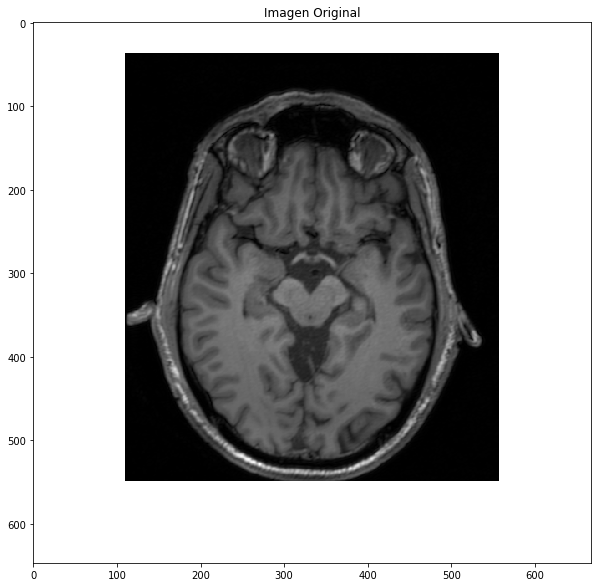

In [3]:
# Imagen Original
degraded = io.imread("imagenes/midbrain.png", as_gray=True)
plt.imshow(degraded, cmap='gray', vmin = 0, vmax = 1)
plt.title("Imagen Original")
plt.show()

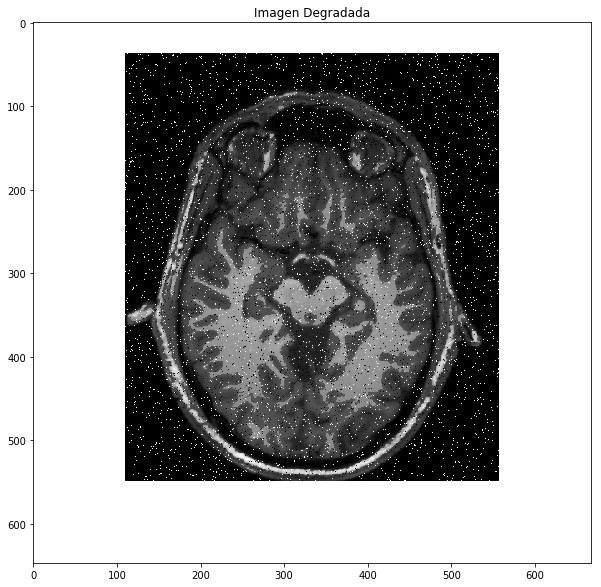

In [4]:
# Imagen Degradada
degraded = io.imread("imagenes/midbrainDegraded.png", as_gray=True)
plt.imshow(degraded, cmap='gray', vmin = 0, vmax = 1)
plt.title("Imagen Degradada")
plt.show()

In [5]:
def change(original):
    changed = np.array(original, copy=True)
    for i in range(original.shape[0]):
        for j in range(original.shape[1]):
            origpx = original[i][j]
            if origpx < 0.4:
                changed[i][j] = (5.0/8.0)*origpx
            elif (origpx > 0.4 and origpx < 0.6):
                changed[i][j] = origpx
            else:
                changed[i][j] = (3.0/8.0)*origpx + (3.0/8.0)    
    return changed

In [6]:
def revert(modified):
    reverted = np.array(modified, copy=True)
    for i in range(modified.shape[0]):
        for j in range(modified.shape[1]):
            modipx = modified[i][j]
            if modipx < 0.4:
                reverted[i][j] = (8.0/5.0)*modipx
            elif (modipx > 0.4 and modipx < 0.6):
                reverted[i][j] = modipx
            else:
                reverted[i][j] = (8.0/3.0)*modipx - 1.0
    return reverted

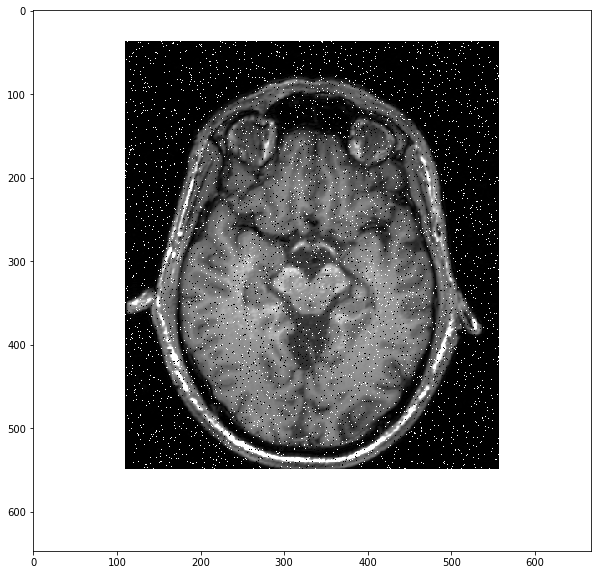

In [8]:
revertcolors = revert(degraded)
plt.imshow(revertcolors, cmap='gray', vmin = 0, vmax = 1)
plt.show()

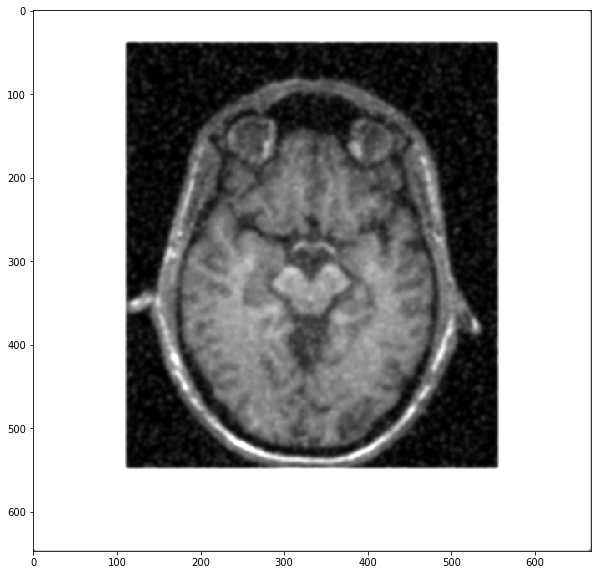

In [25]:
v = [1,10,45,120,210,252,210,120,45,10,1]
blur_kernel = np.outer(v, v)
blur_kernel = blur_kernel / np.sum(blur_kernel)

denoised = revertcolors
for _ in range(2):
    denoised = scipy.signal.convolve2d(denoised, blur_kernel, "same")
plt.imshow(denoised, cmap='gray', vmin = 0, vmax = 1)
plt.show()

#### B) Comparar con imagen perfilada

#### C) Clasificación del mesencéfalo

In [7]:
def mychange(original):
    changed = np.array(original, copy=True)
    for i in range(original.shape[0]):
        for j in range(original.shape[1]):
            origpx = original[i][j]
            if origpx > 0.4:
                changed[i][j] = 1.5*origpx
            else:
                changed[i][j] = 0.666*origpx    
    return changed

In [10]:
def neighbours(pixel):
    neighs = []
    xp1 = pixel.copy()
    xp1[1] = xp1[1] + 1
    neighs.append(xp1)
    xp2 = pixel.copy()
    xp2[0] = xp2[0]+1
    xp2[1] = xp2[1]+1
    neighs.append(xp2)
    
    xp3 = pixel.copy()
    xp3[0] = xp3[0]+1
    neighs.append(xp3)
    
    xp4 = pixel.copy()
    xp4[0] = xp4[0]+1
    xp4[1] = xp4[1]-1
    neighs.append(xp4)
    
    xp5 = pixel.copy()
    xp5[1] = xp5[1]-1
    neighs.append(xp5)
    
    xp6 = pixel.copy()
    xp6[0] = xp6[0]-1
    xp6[1] = xp6[1]-1
    neighs.append(xp6)
    
    xp7 = pixel.copy()
    xp7[0] = xp7[0]-1
    neighs.append(xp7)
    
    xp8 = pixel.copy()
    xp8[0] = xp8[0]-1
    xp8[1] = xp8[1]+1
    neighs.append(xp8)
    return neighs

In [11]:
def distneighs(pixel, image):
    pixval = image[pixel[0], pixel[1]]
    neighs = neighbours(pixel)
    #print("sus vecinos son: ", neighs)
    distance = 0.0
    for elem in neighs:
        elemval = image[elem[0], elem[1]]
        distance += (pixval-elemval)**2
    return math.sqrt(distance)

In [12]:
def reggrow(image, seedpix, threshold):
    new_image = np.array(image, copy=True)
    pixset = set()
    qu = deque([])
    qu.append(seedpix)
    while qu:
        act = qu.pop()
        distance = distneighs(act, denoised)
        if(distance < threshold):
            new_image[act[0], act[1]] = 1
            pixset.add(tuple(act))
            for elem in neighbours(act):
                if tuple(elem) not in pixset:
                    qu.append(elem)
    clean_image = np.array(new_image, copy=True)
    for i in range(clean_image.shape[0]):
        for j in range(clean_image.shape[1]):
            if(clean_image[i][j] != 1):
                clean_image[i][j] = 0
    return clean_image

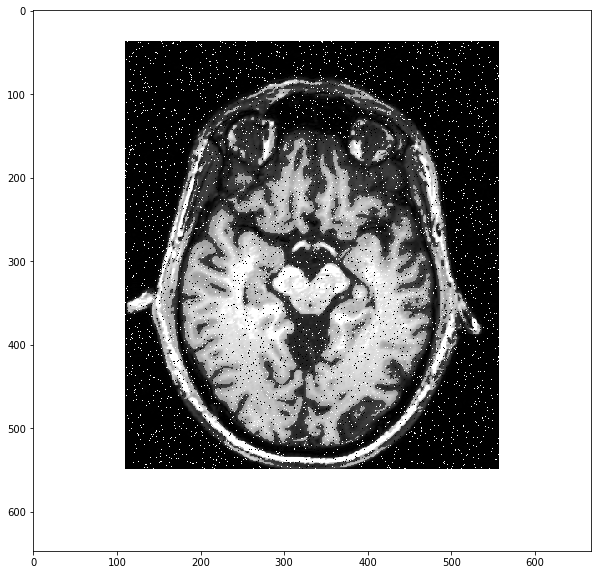

In [9]:
mychanged = mychange(revertcolors)
plt.imshow(mychanged, cmap='gray', vmin = 0, vmax = 1)
plt.show()

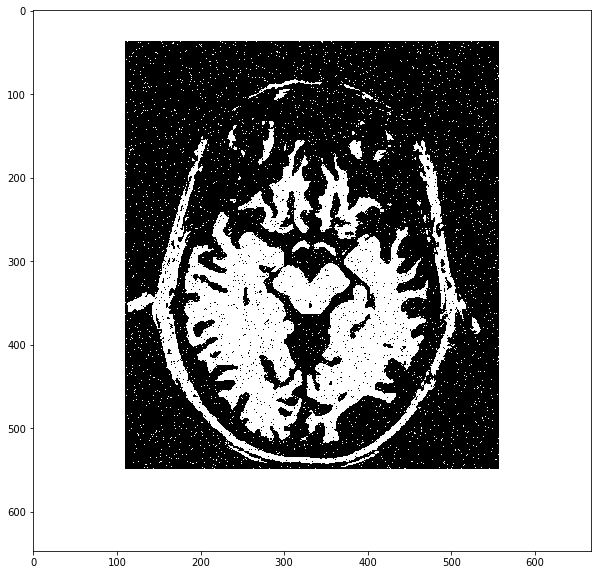

In [13]:
threshimage = mychanged > 0.65
plt.imshow(threshimage, cmap='gray', vmin = 0, vmax = 1)
plt.show()

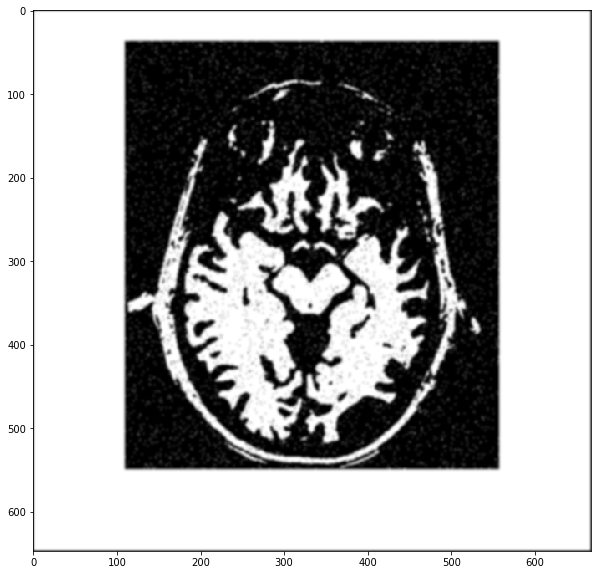

In [17]:
blur_kernel = np.array([[1,1,1],[1,1,1],[1,1,1]])/9.0;
denoised = np.array(threshimage, copy=True)
for i in range(3):
    denoised = scipy.signal.convolve2d(denoised, blur_kernel, "same")
plt.imshow(denoised, cmap='gray', vmin = 0, vmax = 1)
plt.show()

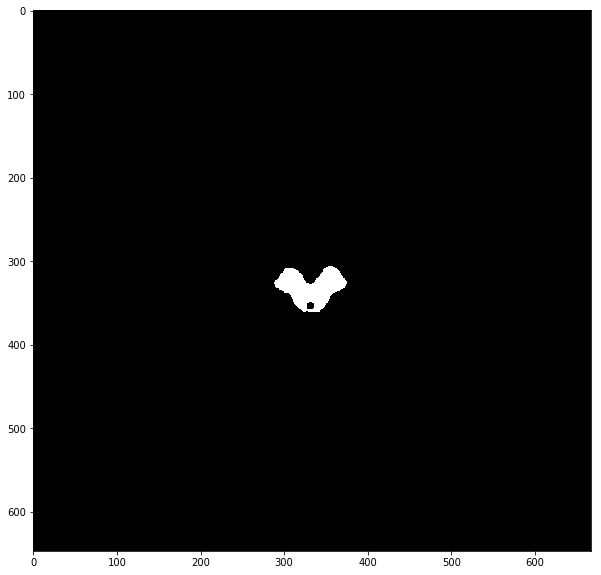

In [15]:
newimage = reggrow(denoised, [327,339], 0.2)
plt.imshow(newimage, cmap='gray', vmin = 0, vmax = 1)
plt.show()

### Conclusione